In [1]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Conv2D, MaxPooling2D, Flatten, advanced_activations, UpSampling2D
from keras.optimizers import SGD, Adam
from keras.utils import np_utils
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = np_utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        if i % 10 == 0:
            print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]


In [3]:
[X_train, Y_train] = generate_dataset_classification(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


Text(0.5,0,'disk')

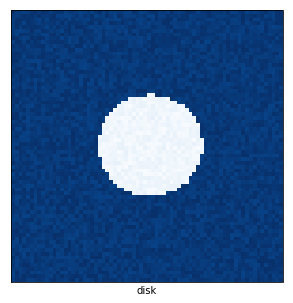

In [4]:
class_names = ['rectangle', 'disk', 'triangle']
plt.figure(figsize=(5,5))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.imshow(X_train[12].reshape(72,72), cmap= 'Blues')
plt.xlabel(class_names[int(Y_train[12])])

In [5]:
y_train = np_utils.to_categorical(Y_train, 3)

<font color = black> 
    
# SGD

In [6]:
model_sgd = Sequential()
model_sgd.add(Dense(16, activation = 'relu'))
model_sgd.add(Dense(3, activation = 'softmax'))

sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov=True)
model_sgd.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])

model_sgd.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 861us/step - loss: 0.2548 - acc: 0.2208 - val_loss: 0.2302 - val_acc: 0.3000
Epoch 2/20
240/240 [==============================] - 0s 135us/step - loss: 0.2232 - acc: 0.3583 - val_loss: 0.2066 - val_acc: 0.5833
Epoch 3/20
240/240 [==============================] - 0s 174us/step - loss: 0.2085 - acc: 0.5458 - val_loss: 0.1951 - val_acc: 0.6000
Epoch 4/20
240/240 [==============================] - 0s 169us/step - loss: 0.1983 - acc: 0.6167 - val_loss: 0.1833 - val_acc: 0.6500
Epoch 5/20
240/240 [==============================] - 0s 164us/step - loss: 0.1879 - acc: 0.7333 - val_loss: 0.1720 - val_acc: 0.7667
Epoch 6/20
240/240 [==============================] - 0s 160us/step - loss: 0.1781 - acc: 0.7500 - val_loss: 0.1622 - val_acc: 0.8167
Epoch 7/20
240/240 [==============================] - 0s 158us/step - loss: 0.1696 - acc: 0.8000 - val_loss: 0.1576 - val_acc: 0.8500
Epoch 8/20
240/24

In [7]:
X_test = generate_a_triangle()[0]
X_test = X_test.reshape(1, X_test.shape[0]) 
model_sgd.predict(X_test)

array([[0., 0., 1.]], dtype=float32)

<font color = black> 
    
# Adam

In [8]:
model_adam = Sequential()
model_adam.add(Dense(16, activation = 'relu'))
model_adam.add(Dense(3, activation = 'softmax'))

model_adam.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_adam.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 1ms/step - loss: 2.4837 - acc: 0.4125 - val_loss: 1.8220 - val_acc: 0.3833
Epoch 2/20
240/240 [==============================] - 0s 141us/step - loss: 1.3312 - acc: 0.4792 - val_loss: 0.3831 - val_acc: 0.8667
Epoch 3/20
240/240 [==============================] - 0s 185us/step - loss: 0.6003 - acc: 0.6750 - val_loss: 0.3727 - val_acc: 0.8167
Epoch 4/20
240/240 [==============================] - 0s 193us/step - loss: 0.4870 - acc: 0.7333 - val_loss: 0.4425 - val_acc: 0.8333
Epoch 5/20
240/240 [==============================] - 0s 188us/step - loss: 0.4336 - acc: 0.7667 - val_loss: 0.3472 - val_acc: 0.8500
Epoch 6/20
240/240 [==============================] - 0s 168us/step - loss: 0.4151 - acc: 0.7958 - val_loss: 0.3233 - val_acc: 0.8333
Epoch 7/20
240/240 [==============================] - 0s 150us/step - loss: 0.3821 - acc: 0.7917 - val_loss: 0.2186 - val_acc: 0.9000
Epoch 8/20
240/240 

In [9]:
X_test = generate_a_rectangle()
X_test = X_test.reshape(1, X_test.shape[0]) 
model_adam.predict(X_test)

array([[1., 0., 0.]], dtype=float32)

<font color = black> 
    
# Visualization of the Solution

Text(0.5,1,'Sgd - Triangle')

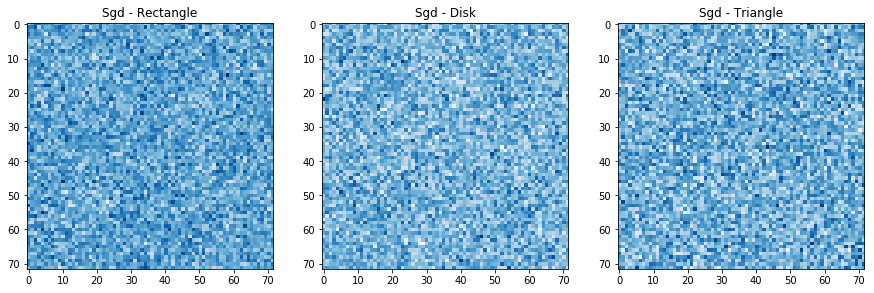

In [10]:
weights_sgd = model_sgd.get_weights()[0] @ model_sgd.get_weights()[2]
weights_adam = model_adam.get_weights()[0] @ model_adam.get_weights()[2]
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(weights_sgd[:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
axes[0].set_title('Sgd - Rectangle')

axes[1].imshow(weights_sgd[:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
axes[1].set_title('Sgd - Disk')

axes[2].imshow(weights_sgd[:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
axes[2].set_title('Sgd - Triangle')

Text(0.5,1,'Adam - Triangle')

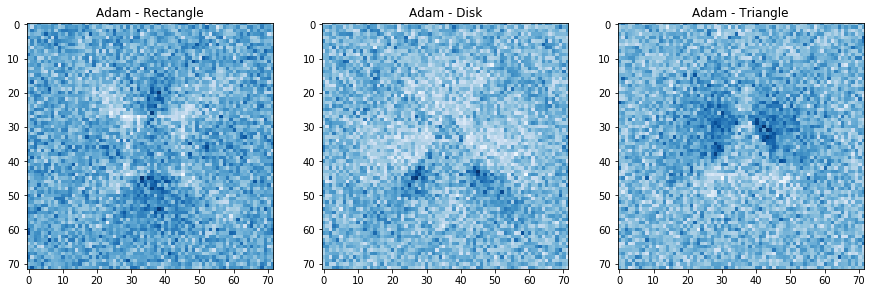

In [11]:
fig, axes = plt.subplots(1, 3, figsize=(15, 15))

axes[0].imshow(weights_adam[:, 0].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
axes[0].set_title('Adam - Rectangle')

axes[1].imshow(weights_adam[:, 1].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
axes[1].set_title('Adam - Disk')

axes[2].imshow(weights_adam[:, 2].reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='Blues')
axes[2].set_title('Adam - Triangle')

In [12]:
[X_train, Y_train] = generate_dataset_classification(300, 20, True)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [13]:
[X_test, Y_test] = generate_test_set_classification()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [14]:
y_train = np_utils.to_categorical(Y_train, 3)

Text(0.5,0,'triangle')

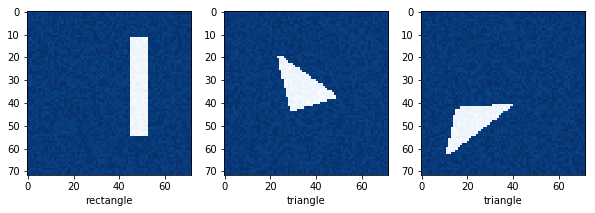

In [15]:
class_names = ['rectangle', 'disk', 'triangle']
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(1,3,1)
plt.imshow(X_train[5].reshape(72,72), cmap= 'Blues')
plt.xlabel(class_names[int(Y_train[5])])
plt.subplot(1,3,2)
plt.imshow(X_train[9].reshape(72,72), cmap= 'Blues')
plt.xlabel(class_names[int(Y_train[9])])
plt.subplot(1,3,3)
plt.imshow(X_train[15].reshape(72,72), cmap= 'Blues')
plt.xlabel(class_names[int(Y_train[15])])

In [16]:
model_test = Sequential()
model_test.add(Dense(16, activation = 'relu'))
model_test.add(Dense(3, activation = 'softmax'))

sgd = SGD(lr = 0.001, decay = 1e-6, momentum = 0.9, nesterov=True)
model_test.compile(loss = 'mean_squared_error', optimizer = sgd, metrics = ['accuracy'])

model_test.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 0s 1ms/step - loss: 0.2407 - acc: 0.3417 - val_loss: 0.2292 - val_acc: 0.3667
Epoch 2/20
240/240 [==============================] - 0s 128us/step - loss: 0.2202 - acc: 0.3875 - val_loss: 0.2268 - val_acc: 0.3167
Epoch 3/20
240/240 [==============================] - 0s 145us/step - loss: 0.2169 - acc: 0.4667 - val_loss: 0.2332 - val_acc: 0.3000
Epoch 4/20
240/240 [==============================] - 0s 170us/step - loss: 0.2088 - acc: 0.5292 - val_loss: 0.2110 - val_acc: 0.5000
Epoch 5/20
240/240 [==============================] - 0s 169us/step - loss: 0.2080 - acc: 0.5458 - val_loss: 0.2157 - val_acc: 0.4667
Epoch 6/20
240/240 [==============================] - 0s 155us/step - loss: 0.1989 - acc: 0.5708 - val_loss: 0.2678 - val_acc: 0.2667
Epoch 7/20
240/240 [==============================] - 0s 181us/step - loss: 0.2066 - acc: 0.5125 - val_loss: 0.2027 - val_acc: 0.5167
Epoch 8/20
240/240 

In [17]:
score = model_test.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

300/300 [==============================] - 0s 92us/step
Test loss: 0.20136082351207732
Test accuracy: 0.5066666662693023


In [18]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

In [19]:
model_conv = Sequential()

model_conv.add(Conv2D(32, (5, 5), activation = 'relu', input_shape = (72, 72, 1)))
print(model_conv.output_shape)

model_conv.add(MaxPooling2D(pool_size=(2, 2)))
print(model_conv.output_shape)

model_conv.add(Flatten())
print(model_conv.output_shape)

model_conv.add(Dense(3, activation = 'softmax'))
print(model_conv.output_shape)

model_conv.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model_conv.fit(X_train, y_train, epochs = 20, batch_size=32, validation_split = 0.2)

(None, 68, 68, 32)
(None, 34, 34, 32)
(None, 36992)
(None, 3)
Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 1s 6ms/step - loss: 1.6223 - acc: 0.3042 - val_loss: 1.0964 - val_acc: 0.2667
Epoch 2/20
240/240 [==============================] - 1s 4ms/step - loss: 1.0183 - acc: 0.4792 - val_loss: 0.9756 - val_acc: 0.6000
Epoch 3/20
240/240 [==============================] - 1s 4ms/step - loss: 0.8480 - acc: 0.7667 - val_loss: 0.9074 - val_acc: 0.7167
Epoch 4/20
240/240 [==============================] - 1s 4ms/step - loss: 0.7350 - acc: 0.7958 - val_loss: 0.8581 - val_acc: 0.7000
Epoch 5/20
240/240 [==============================] - 1s 4ms/step - loss: 0.6488 - acc: 0.7750 - val_loss: 0.8856 - val_acc: 0.5667
Epoch 6/20
240/240 [==============================] - 1s 4ms/step - loss: 0.5703 - acc: 0.8125 - val_loss: 0.8554 - val_acc: 0.5667
Epoch 7/20
240/240 [==============================] - 1s 4ms/step - loss: 0.5563 - acc: 0.8042 - val_

In [20]:
score = model_conv.evaluate(X_test, Y_test)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

300/300 [==============================] - 0s 2ms/step
Test loss: 0.7957019551595053
Test accuracy: 0.6899999992052714


In [21]:
y_conv_pred = model_conv.predict(X_test)

Text(0.5,0,'Prediction:rectangle')

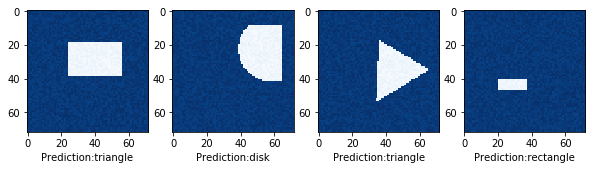

In [22]:
class_names = ['rectangle', 'disk', 'triangle']

plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)

plt.subplot(1,4,1)
plt.imshow(X_test[98].reshape(72,72), cmap= 'Blues')
plt.xlabel('Prediction:' + class_names[np.argmax(y_conv_pred[98])])
         
plt.subplot(1,4,2)
plt.imshow(X_test[147].reshape(72,72), cmap= 'Blues')
plt.xlabel('Prediction:' + class_names[np.argmax(y_conv_pred[147])])
         
plt.subplot(1,4,3)
plt.imshow(X_test[1].reshape(72,72), cmap= 'Blues')
plt.xlabel('Prediction:' + class_names[np.argmax(y_conv_pred[1])])

plt.subplot(1,4,4)
plt.imshow(X_test[89].reshape(72,72), cmap= 'Blues')
plt.xlabel('Prediction:' + class_names[np.argmax(y_conv_pred[89])])

<font color = black> 
    
# A Regression Problem

In [23]:
[X_train, Y_train] = generate_dataset_regression(300, 20)

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


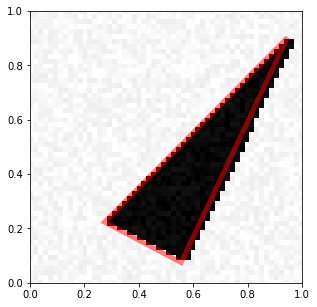

In [24]:
visualize_prediction(X_train[0], Y_train[0])

In [25]:
[X_test, Y_test] = generate_test_set_regression()

Creating data:
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290


In [26]:
def normalizer(array):
    nb_samples = array.shape[0]
    normalized_array = np.copy(array)
    
    for k in range(nb_samples):
        x1, y1, x2, y2, x3, y3 = array[k, 0], array[k, 1], array[k, 2], array[k, 3], array[k, 4], array[k, 5]
        couple = {y1:x1, y2:x2, y3:x3}
        couple_list = list(couple)
        couple_list.sort()
        normalized = []
        
        for key in couple_list:
            normalized.append(couple[key])
            normalized.append(key)
        
        normalized_array[k] = normalized
    
    return(normalized_array)

In [27]:
Y_train_norm = normalizer(Y_train)
Y_test_norm = normalizer(Y_test)

In [28]:
X_train = X_train.reshape(X_train.shape[0], 72, 72, 1) 
X_test = X_test.reshape(X_test.shape[0], 72, 72, 1)

In [29]:
X_train.shape

(300, 72, 72, 1)

In [30]:
model_regression = Sequential()

model_regression.add(Conv2D(32, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Conv2D(64, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Conv2D(128, (3, 3), activation = 'relu', input_shape = (72, 72, 1)))
model_regression.add(MaxPooling2D(pool_size=(2, 2)))

model_regression.add(Flatten())

model_regression.add(Dense(128, activation = 'relu'))

model_regression.add(Dense(6, activation = 'linear'))

model_regression.compile(loss = 'mean_squared_error', optimizer = 'adam')

model_regression.fit(X_train, Y_train_norm, epochs = 20, batch_size=32, validation_split = 0.2)

Train on 240 samples, validate on 60 samples
Epoch 1/20
240/240 [==============================] - 3s 12ms/step - loss: 0.1470 - val_loss: 0.1060
Epoch 2/20
240/240 [==============================] - 2s 9ms/step - loss: 0.0771 - val_loss: 0.0637
Epoch 3/20
240/240 [==============================] - 2s 9ms/step - loss: 0.0605 - val_loss: 0.0481
Epoch 4/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0432 - val_loss: 0.0372
Epoch 5/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0343 - val_loss: 0.0309
Epoch 6/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0297 - val_loss: 0.0281
Epoch 7/20
240/240 [==============================] - 2s 9ms/step - loss: 0.0264 - val_loss: 0.0239
Epoch 8/20
240/240 [==============================] - 2s 10ms/step - loss: 0.0218 - val_loss: 0.0224
Epoch 9/20
240/240 [==============================] - 2s 9ms/step - loss: 0.0188 - val_loss: 0.0218
Epoch 10/20
240/240 [=============================

In [31]:
model_regression.evaluate(X_test, Y_test_norm)

300/300 [==============================] - 1s 3ms/step


0.015214690715074539

In [32]:
y_pred = model_regression.predict(X_test)

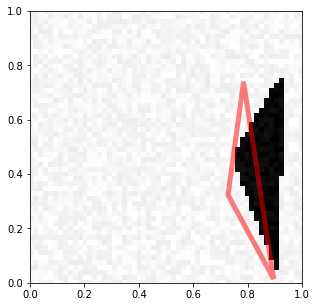

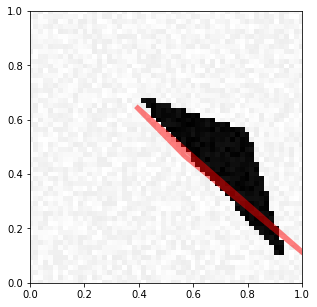

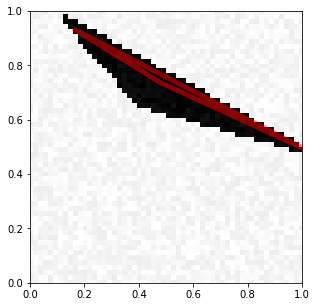

In [33]:
visualize_prediction(X_test[4], y_pred[4])
visualize_prediction(X_test[5], y_pred[5])
visualize_prediction(X_test[6], y_pred[6])

<font color = black> 
    
# Image Denoising

In [34]:
# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing_bis(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle_bis(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return [generate_a_drawing_bis(figsize, U, V, noise), generate_a_drawing_bis(figsize, U, V, 0)]


def generate_a_disk_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return [generate_a_drawing_bis(figsize, U, V, noise), generate_a_drawing_bis(figsize, U, V, 0)]

def generate_a_triangle_bis(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    return [generate_a_drawing_bis(figsize, U, V, noise), generate_a_drawing_bis(figsize, U, V, 0)] 
    

def generate_dataset_classification_bis(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle_bis()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    #print('Creating data:')
    for i in range(nb_samples):
        noise = np.random.randint(255)
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            [X[i], Y[i]] = generate_a_rectangle_bis(noise, free_location)
            
        elif category == 1: 
            [X[i], Y[i]] = generate_a_disk_bis(noise, free_location)
            
        else:
            [X[i], Y[i]] = generate_a_triangle_bis(noise, free_location)
            
        X[i] = (X[i] + noise) / (255 + 2 * noise)
        Y[i] = Y[i] / 255
    return [X, Y]

def generate_test_set_classification_bis():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification_bis(300, free_location=True)
    return [X_test, Y_test]


In [35]:
[X_noised_train, Y_denoised_train] = generate_dataset_classification_bis(600, free_location = True)

In [36]:
[X_noised_test, Y_denoised_test] = generate_test_set_classification_bis()

In [37]:
X_noised_train = X_noised_train.reshape(X_noised_train.shape[0], 72, 72, 1) 
Y_denoised_train = Y_denoised_train.reshape(Y_denoised_train.shape[0], 72, 72, 1) 
X_noised_test = X_noised_test.reshape(X_noised_test.shape[0], 72, 72, 1)
Y_denoised_test = Y_denoised_test.reshape(Y_denoised_test.shape[0], 72, 72, 1)

Text(0.5,1,'image without noise')

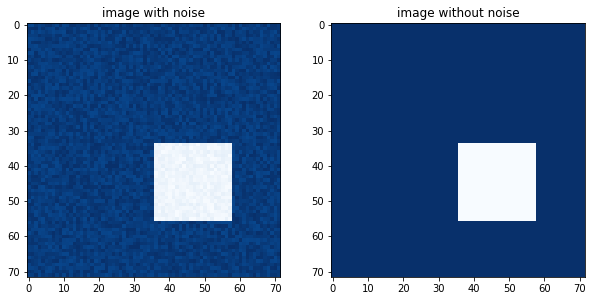

In [38]:
f, axes = plt.subplots(1, 2, figsize=(10,10))

axes[0].imshow(X_noised_train[0].reshape(72,72), cmap= 'Blues')
axes[0].set_title('image with noise')

axes[1].imshow(Y_denoised_train[0].reshape(72,72), cmap= 'Blues')
axes[1].set_title('image without noise')

In [39]:
model_denoise = Sequential()

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear',input_shape=(72,72,1), padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))

model_denoise.add(MaxPooling2D(pool_size=(2, 2)))

model_denoise.add(Conv2D(64, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))

model_denoise.add(MaxPooling2D(pool_size=(2, 2)))

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))

model_denoise.add(UpSampling2D(size=(2, 2)))

model_denoise.add(Conv2D(32, kernel_size=(3,3),activation='linear', padding='same'))
model_denoise.add(UpSampling2D(size=(2, 2)))
model_denoise.add(advanced_activations.LeakyReLU(alpha=0.1))

model_denoise.add(Conv2D(1, kernel_size=(3,3),activation='sigmoid', padding='same'))

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model_denoise.compile(loss='mean_squared_error', optimizer = adam ,metrics=['accuracy'])

model_denoise.fit(X_noised_train, Y_denoised_train, epochs= 10, batch_size = 20, validation_split = 0.2)

Train on 480 samples, validate on 120 samples
Epoch 1/10
480/480 [==============================] - 13s 27ms/step - loss: 0.1001 - acc: 0.9070 - val_loss: 0.0868 - val_acc: 0.9067
Epoch 2/10
480/480 [==============================] - 12s 25ms/step - loss: 0.0617 - acc: 0.9240 - val_loss: 0.0407 - val_acc: 0.9348
Epoch 3/10
480/480 [==============================] - 12s 25ms/step - loss: 0.0192 - acc: 0.9759 - val_loss: 0.0102 - val_acc: 0.9869
Epoch 4/10
480/480 [==============================] - 12s 24ms/step - loss: 0.0078 - acc: 0.9898 - val_loss: 0.0064 - val_acc: 0.9923
Epoch 5/10
480/480 [==============================] - 12s 24ms/step - loss: 0.0058 - acc: 0.9928 - val_loss: 0.0060 - val_acc: 0.9923
Epoch 6/10
480/480 [==============================] - 12s 24ms/step - loss: 0.0053 - acc: 0.9934 - val_loss: 0.0054 - val_acc: 0.9931
Epoch 7/10
480/480 [==============================] - 12s 24ms/step - loss: 0.0049 - acc: 0.9938 - val_loss: 0.0060 - val_acc: 0.9918
Epoch 8/10
480/4

In [40]:
Y_pred_denoised = model_denoise.predict(X_noised_test)

Text(0.5,0,'With no noise prediction')

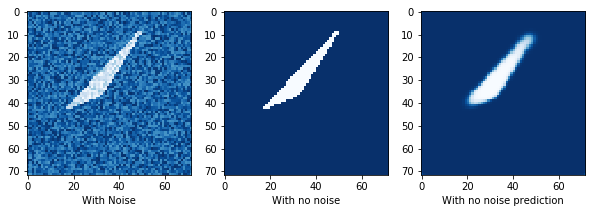

In [41]:
plt.figure(figsize=(10,10))
plt.xticks([])
plt.yticks([])
plt.grid(False)
plt.subplot(1,3,1)
plt.imshow(X_noised_test[113].reshape(72,72), cmap= 'Blues')
plt.xlabel('With Noise')
plt.subplot(1,3,2)
plt.imshow(Y_denoised_test[113].reshape(72,72), cmap= 'Blues')
plt.xlabel('With no noise')
plt.subplot(1,3,3)
plt.imshow(Y_pred_denoised[113].reshape(72,72), cmap= 'Blues')
plt.xlabel('With no noise prediction')